# Figure 6

- Panel A: Plate map figure for Plate 6
- Panel B: UMAP of Plate 6 single-cells using model feature space
- Panel C: PR curve of Plate 6
- Panel D: Accuracy bar plot of Plate 6
- Panel E: KS-test results for different cell line derivatives of Plate 6

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(arrow))
suppressPackageStartupMessages(library(RColorBrewer))

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


## Set paths

In [2]:
figure_dir <- "../figures"
output_main_figure_6 <- file.path(
    figure_dir, "main_figure_6_cell_line_generalizability.png"
)
results_dir <- file.path(
    "../../3.assess_generalizability/results"
)

## UMAP

In [3]:
# Load in platemap data
platemap_df <- read.csv(
    "/media/18tbdrive/1.Github_Repositories/nf1_schwann_cell_painting_data/0.download_data/metadata/platemap_NF1_plate6.csv"
)

# Path to UMAP results
UMAP_results_dir <- file.path(
    "/media/18tbdrive/1.Github_Repositories/nf1_schwann_cell_painting_data/4.analyze_data/notebooks/UMAP/results/qc_profiles_results"
)

# Subset the data frame and rename columns
platemap_df_filtered <- platemap_df[, c("well_position", "Institution")]
colnames(platemap_df_filtered) <- c("Metadata_Well", "Metadata_Institution")

# Load data
UMAP_results_file <- file.path(UMAP_results_dir, "UMAP_Plate_6_sc_only_model_features_qc.tsv")

UMAP_results_df <- readr::read_tsv(UMAP_results_file)

# Merge institution info onto UMAP df
UMAP_results_df <- platemap_df_filtered %>% inner_join(UMAP_results_df, by = "Metadata_Well")

# Add new column for cell line derivative
UMAP_results_df <- UMAP_results_df %>%
    mutate(cell_line_derivative = ifelse(Metadata_Institution == "iNFixion", "original", 
        ifelse(Metadata_Institution == "MGH", "derivative", NA)))

# Add new column for cell line code
UMAP_results_df <- UMAP_results_df %>%
    mutate(cell_line_code = case_when(
        Metadata_Institution == "iNFixion" & Metadata_genotype == "Null" ~ "C04",
        Metadata_Institution == "iNFixion" & Metadata_genotype == "WT" ~ "A3",
        Metadata_Institution == "MGH" & Metadata_genotype == "WT" ~ "GFP 3",
        Metadata_Institution == "MGH" & Metadata_genotype == "Null" ~ "C23",
        TRUE ~ NA_character_
    ))

dim(UMAP_results_df)
head(UMAP_results_df)

Rows: 4395 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Metadata_Well, Metadata_genotype, Metadata_Plate
dbl (4): Metadata_Site, Metadata_number_of_singlecells, UMAP0, UMAP1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 4395   10

,Metadata_Well,Metadata_Institution,Metadata_Site,Metadata_number_of_singlecells,Metadata_genotype,Metadata_Plate,UMAP0,UMAP1,cell_line_derivative,cell_line_code
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,B2,iNFixion,7,129,WT,Plate_6_filtered,10.024970,4.677549,original,A3
2,B2,iNFixion,9,129,WT,Plate_6_filtered,9.495263,3.890662,original,A3
3,B2,iNFixion,2,129,WT,Plate_6_filtered,8.150915,4.075218,original,A3
4,B2,iNFixion,4,129,WT,Plate_6_filtered,9.883081,5.361924,original,A3
5,B2,iNFixion,22,129,WT,Plate_6_filtered,9.748680,3.917263,original,A3
6,B2,iNFixion,17,129,WT,Plate_6_filtered,10.149612,3.330395,original,A3


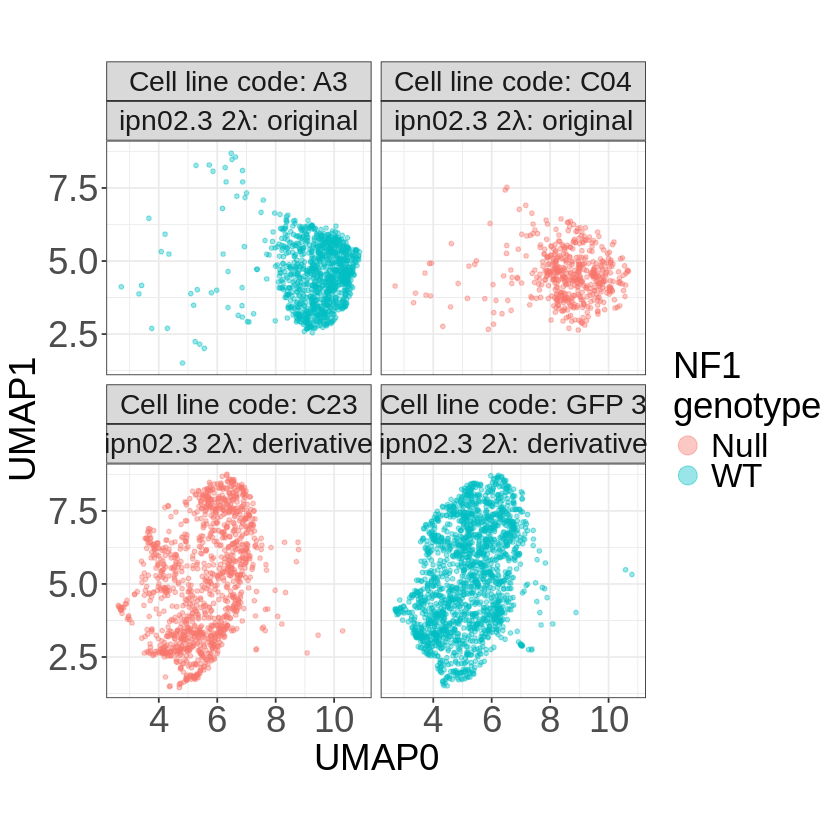

In [4]:
umap_fig_gg <- (
    ggplot(UMAP_results_df, aes(x = UMAP0, y = UMAP1)) +
    geom_point(
        aes(color = Metadata_genotype),
        size = 1.0,
        alpha = 0.4
    ) +
    theme_bw() +
    guides(
        color = guide_legend(
            override.aes = list(size = 5)
        )
    ) +
    labs(x = "UMAP0", y = "UMAP1", color = "NF1\ngenotype") +
    facet_wrap(
        cell_line_code ~ cell_line_derivative, 
        labeller = labeller(
            cell_line_code = function(x) paste("Cell line code:", x),
            cell_line_derivative = function(x) paste("ipn02.3 2λ:", x)
        )
    ) +
    coord_fixed(ratio = 1.0) + 
    # Change the text size
    theme(
        strip.text = element_text(size = 17),
        # X and Y axis text size
        axis.text.x = element_text(size = 22),
        axis.text.y = element_text(size = 22),
        # X and Y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # Legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22)
    )
)

umap_fig_gg

## PR curve

In [5]:
# Load data (includes optimization in this file)
PR_results_file <- file.path(results_dir, "plate6_precision_recall_final_model_qc.parquet")

PR_results_df <- arrow::read_parquet(PR_results_file)

# Create new column for model using the datasplit prefix
PR_results_df <- PR_results_df %>%
  mutate(shuffled_type = ifelse(grepl("^shuffled", data_type), "TRUE", "FALSE"))

# Add new column for cell line derivative
PR_results_df <- PR_results_df %>%
    mutate(cell_line_derivative = ifelse(Metadata_Institution == "iNFixion", "original", ifelse(Metadata_Institution == "MGH", "derivative", NA)))

dim(PR_results_df)
head(PR_results_df)

[1] 8536    6

Precision,Recall,Metadata_Institution,data_type,shuffled_type,cell_line_derivative
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
0.6778010,1.0000000,iNFixion,final,FALSE,original
0.6775766,0.9989733,iNFixion,final,FALSE,original
0.6773519,0.9979466,iNFixion,final,FALSE,original
0.6771269,0.9969199,iNFixion,final,FALSE,original
0.6769016,0.9958932,iNFixion,final,FALSE,original
0.6773743,0.9958932,iNFixion,final,FALSE,original


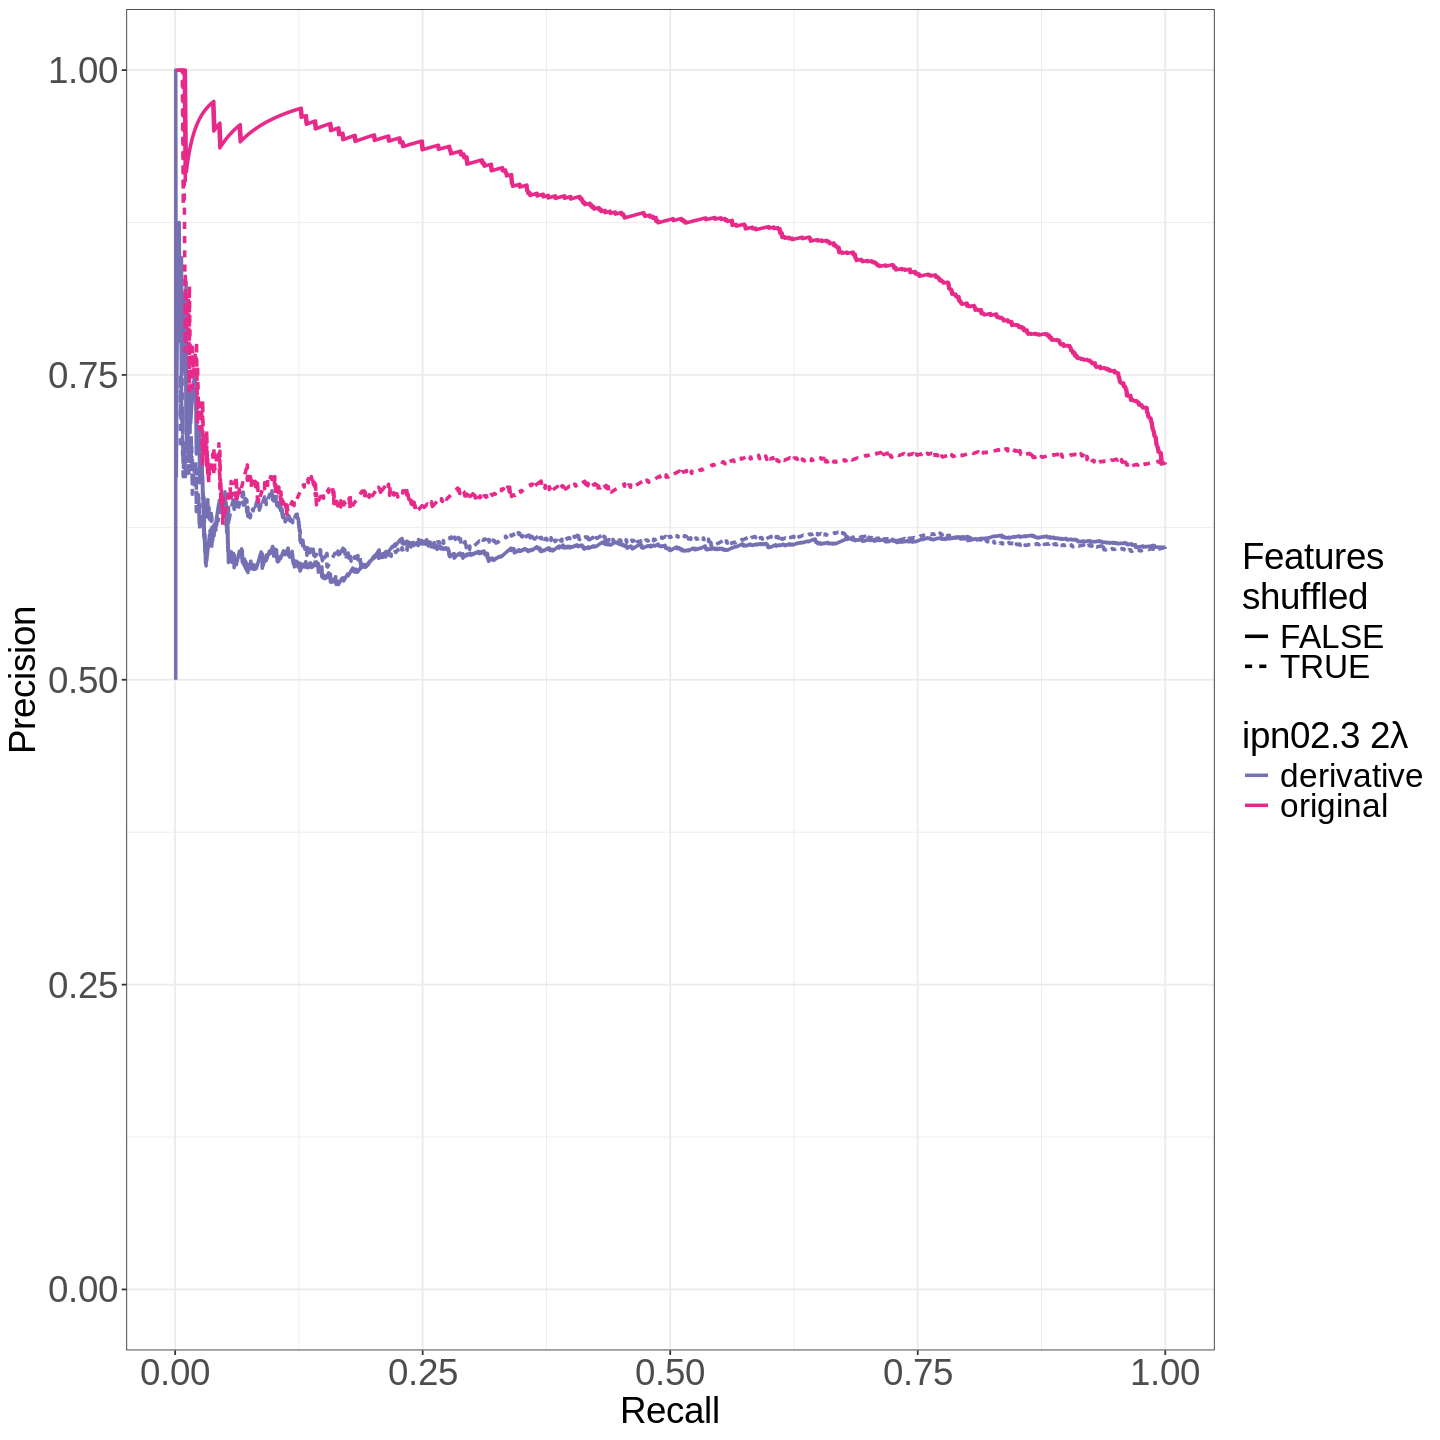

In [6]:
width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

pr_curve_plot <- (
    ggplot(PR_results_df, aes(x = Recall, y = Precision, color = cell_line_derivative, linetype = shuffled_type))
    + geom_line(aes(linetype = shuffled_type), linewidth = 1)
    + theme_bw()
    # + coord_fixed()
    + labs(color = "ipn02.3 2λ", linetype = "Features\nshuffled", x = "Recall", y = "Precision")
    # change the colors
    + scale_color_manual(values = c(
        "original" = brewer.pal(8, "Dark2")[4],
        "derivative" = brewer.pal(8, "Dark2")[3]
    ))
    + scale_y_continuous(limits = c(0, 1))
    # change the line thickness of the lines in the legend
    + guides(linetype = guide_legend(override.aes = list(size = 1)))
    # change the text size
    + theme(
        # x and y axis text size
        axis.text.x = element_text(size = 22),
        axis.text.y = element_text(size = 22),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
    )
)

pr_curve_plot

## Accuracy bar plot

In [7]:
# Load data
accuracy_results_file <- file.path(results_dir, "plate6_accuracy_final_model_qc.parquet")

accuracy_results_df <- arrow::read_parquet(accuracy_results_file)

# Create new column for model using the datasplit prefix
accuracy_results_df <- accuracy_results_df %>%
  mutate(shuffled_type = ifelse(grepl("^shuffled", data_type), "TRUE", "FALSE"))

# Add new column for cell line derivative
accuracy_results_df <- accuracy_results_df %>%
    mutate(cell_line_derivative = ifelse(Metadata_Institution == "iNFixion", "original", ifelse(Metadata_Institution == "MGH", "derivative", NA)))

dim(accuracy_results_df)
head(accuracy_results_df)

[1] 4 5

Metadata_Institution,data_type,accuracy,shuffled_type,cell_line_derivative
<chr>,<chr>,<dbl>,<chr>,<chr>
MGH,final,0.4966538,FALSE,derivative
MGH,shuffled,0.4994716,TRUE,derivative
iNFixion,final,0.6868476,FALSE,original
iNFixion,shuffled,0.5003479,TRUE,original


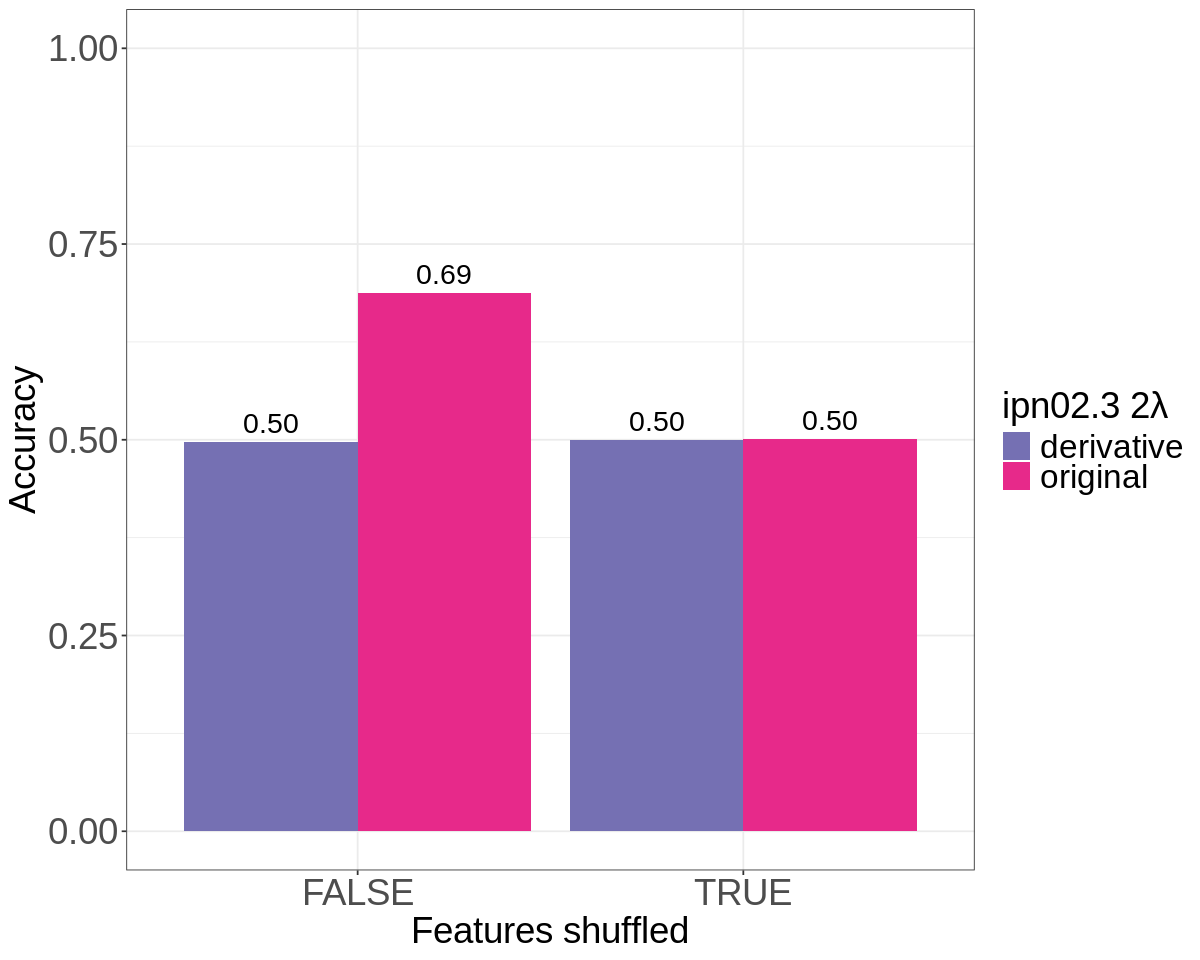

In [8]:
width <- 10
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
# bar plot of the accuracy scores
accuracy_score_plot <- (
    ggplot(accuracy_results_df, aes(x = shuffled_type, y = accuracy, fill = cell_line_derivative))
    + geom_bar(stat = "identity", position = "dodge")

    # Add text labels for accuracy scores on top of bars
    + geom_text(
        aes(label = sprintf("%.2f", accuracy)), 
        position = position_dodge(width = 0.9), 
        vjust = -0.5, 
        size = 6
    )

    + ylim(0, 1)
    + theme_bw()
    + ylab("Accuracy")
    + xlab("Features shuffled")
    # change the legend title
    + labs(fill = "ipn02.3 2λ")
    # change the colours
    + scale_fill_manual(values = c(
        "original" = brewer.pal(8, "Dark2")[4],
        "derivative" = brewer.pal(8, "Dark2")[3]
    ))
    # change the text size
    + theme(
        # x and y axis text size
        axis.text.x = element_text(size = 22),
        axis.text.y = element_text(size = 22),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
    )
)

accuracy_score_plot

## KS-test

In [9]:
# Load data
kstest_results_file <- file.path("../../3.assess_generalizability/results/ks_test_derivatives_results_qc.parquet")

kstest_results_df <- arrow::read_parquet(kstest_results_file)

# Filter for genotype_comparison == "All"
kstest_results_df <- kstest_results_df %>%
    filter(genotype_comparison == "All")

# Create a new column extracting the first part of 'feature' after the compartment
kstest_results_df$feature_base <- sub("^[^_]+_", "", kstest_results_df$feature)

# Update the channel column where anything other than DAPI, CY5, GFP, or RFP is called "other"
kstest_results_df$channel <- ifelse(kstest_results_df$channel %in% c("DAPI", "CY5", "GFP", "RFP"), kstest_results_df$channel, "Other")

# Update the channel names
kstest_results_df$channel <- recode(kstest_results_df$channel, "DAPI" = "Nuclei", "GFP" = "ER", "CY5" = "Mito", "RFP" = "F-actin")

dim(kstest_results_df)
head(kstest_results_df)

[1] 894  14

feature,ks_stat,p_value,genotype_comparison,feature_importances,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,__index_level_0__,feature_base
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
Cytoplasm_AreaShape_Eccentricity,0.05430353,2.483386e-04,All,0.03499314,Cytoplasm,AreaShape,Eccentricity,Other,NA,NA,NA,2,AreaShape_Eccentricity
Cytoplasm_AreaShape_FormFactor,0.30094901,8.887027e-122,All,1.23824428,Cytoplasm,AreaShape,FormFactor,Other,NA,NA,NA,5,AreaShape_FormFactor
Cytoplasm_AreaShape_MajorAxisLength,0.48560346,4.540463e-321,All,0.05524868,Cytoplasm,AreaShape,MajorAxisLength,Other,NA,NA,NA,8,AreaShape_MajorAxisLength
Cytoplasm_AreaShape_MinorAxisLength,0.55235009,3.320121e-321,All,0.11914011,Cytoplasm,AreaShape,MinorAxisLength,Other,NA,NA,NA,11,AreaShape_MinorAxisLength
Cytoplasm_AreaShape_Solidity,0.20656664,3.973060e-57,All,1.35175282,Cytoplasm,AreaShape,Solidity,Other,NA,NA,NA,14,AreaShape_Solidity
Cytoplasm_AreaShape_Zernike_2_0,0.07953342,8.530723e-09,All,0.33062934,Cytoplasm,AreaShape,Zernike,Other,0,NA,NA,17,AreaShape_Zernike_2_0


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


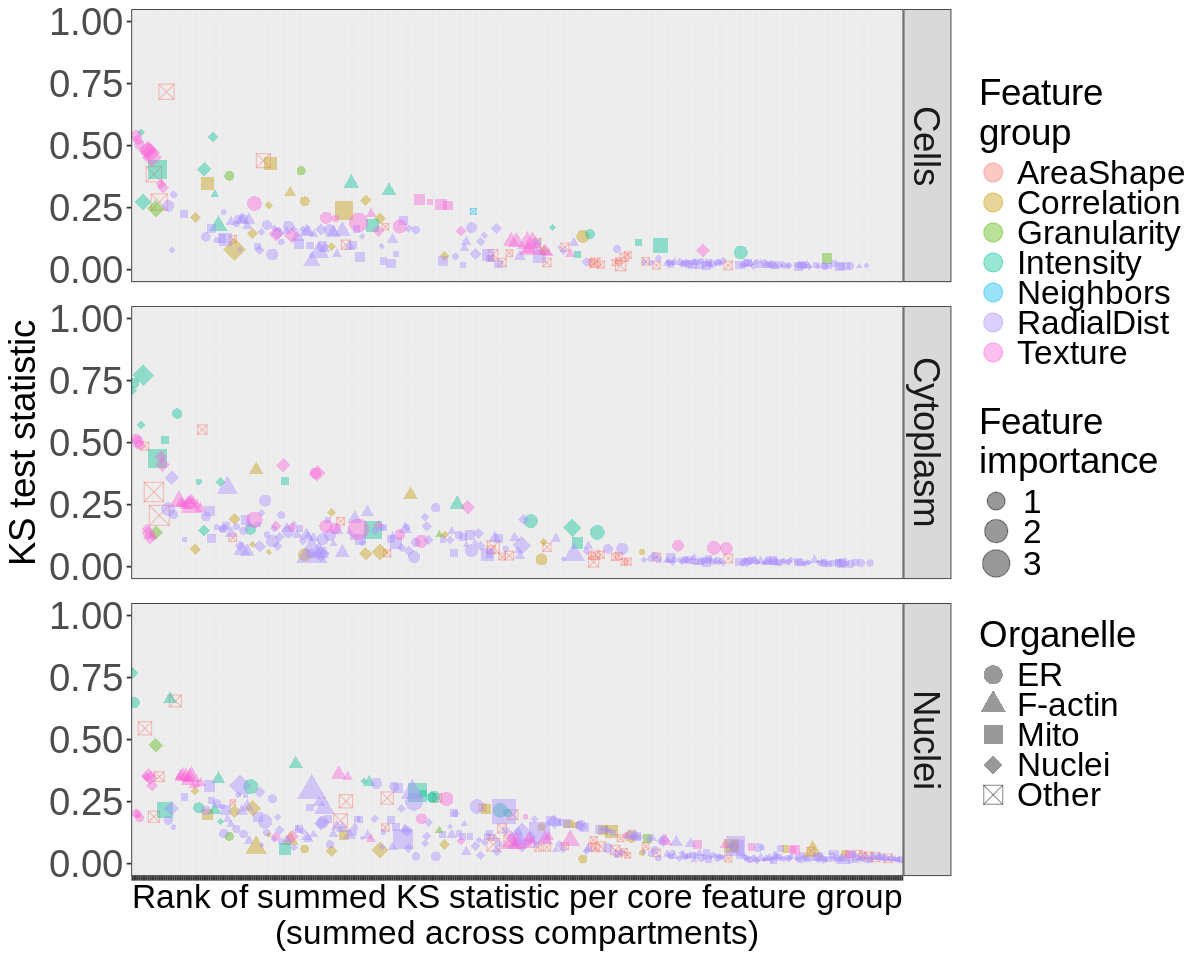

In [10]:
width <- 10
height <- 8
options(repr.plot.width = width, repr.plot.height = height)

# Update feature group name
kstest_results_df$feature_group <- ifelse(kstest_results_df$feature_group == "RadialDistribution", "RadialDist", kstest_results_df$feature_group)

# Reorder feature_base based on the sum of the base feature across all compartments
kstest_results_df$feature_base <- factor(kstest_results_df$feature_base, 
                                         levels = kstest_results_df %>% 
                                           group_by(feature_base) %>% 
                                           summarise(total_ks = sum(ks_stat)) %>% 
                                           arrange(desc(total_ks)) %>% 
                                           pull(feature_base))

# Create the plot
ks_test_scatter <- (
    ggplot(kstest_results_df, aes(x = feature_base, y = ks_stat))
    + geom_point(aes(color = feature_group, size = feature_importances, shape = channel), alpha = 0.4) 
    + theme_bw()
    + facet_grid(compartment ~ .)
    + theme(
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 23),
        axis.title.x = element_text(size = 20),
        axis.title.y = element_text(size = 22),
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
        strip.text = element_text(size = 22),
        panel.spacing = unit(1, "lines"),
        legend.position = "right"
    )
    + ylim(0,1)
    + scale_color_discrete(name = "Feature\ngroup")
    + scale_size_continuous(name = "Feature\nimportance", range = c(1, 8)) 
    + scale_shape_manual(name = "Organelle", values = c(16, 17, 15, 18, 7))
    + labs(
        x = "Rank of summed KS statistic per core feature group\n(summed across compartments)",
        y = "KS test statistic"
    )
    + guides(
    shape = guide_legend(override.aes = list(size = 5)), 
    color = guide_legend(override.aes = list(size = 5))
    )
)

ks_test_scatter

## Platemap

In [11]:
# Drop rows where genotype is 'HET'
platemap_df <- platemap_df %>%
    filter(genotype != "HET")

# Add new column for cell line code
platemap_df <- platemap_df %>%
    mutate(cell_line_code = case_when(
        Institution == "iNFixion" & genotype == "Null" ~ "C04",
        Institution == "iNFixion" & genotype == "WT" ~ "A3",
        Institution == "MGH" & genotype == "WT" ~ "GFP 3",
        Institution == "MGH" & genotype == "Null" ~ "C23",
        TRUE ~ NA_character_
    ))

head(platemap_df)

,WellRow,WellCol,well_position,gene_name,genotype,Institution,seed_density,cell_line_code
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,B,2,B2,NF1,WT,iNFixion,1000,A3
2,B,3,B3,NF1,WT,iNFixion,1000,A3
3,B,4,B4,NF1,WT,iNFixion,1000,A3
4,B,5,B5,NF1,WT,iNFixion,1000,A3
5,B,6,B6,NF1,WT,iNFixion,1000,A3
6,B,7,B7,NF1,WT,iNFixion,1000,A3


Warning message:
“Warning: Your well label count ( 40 ) covers less than half the selected plate( 96 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


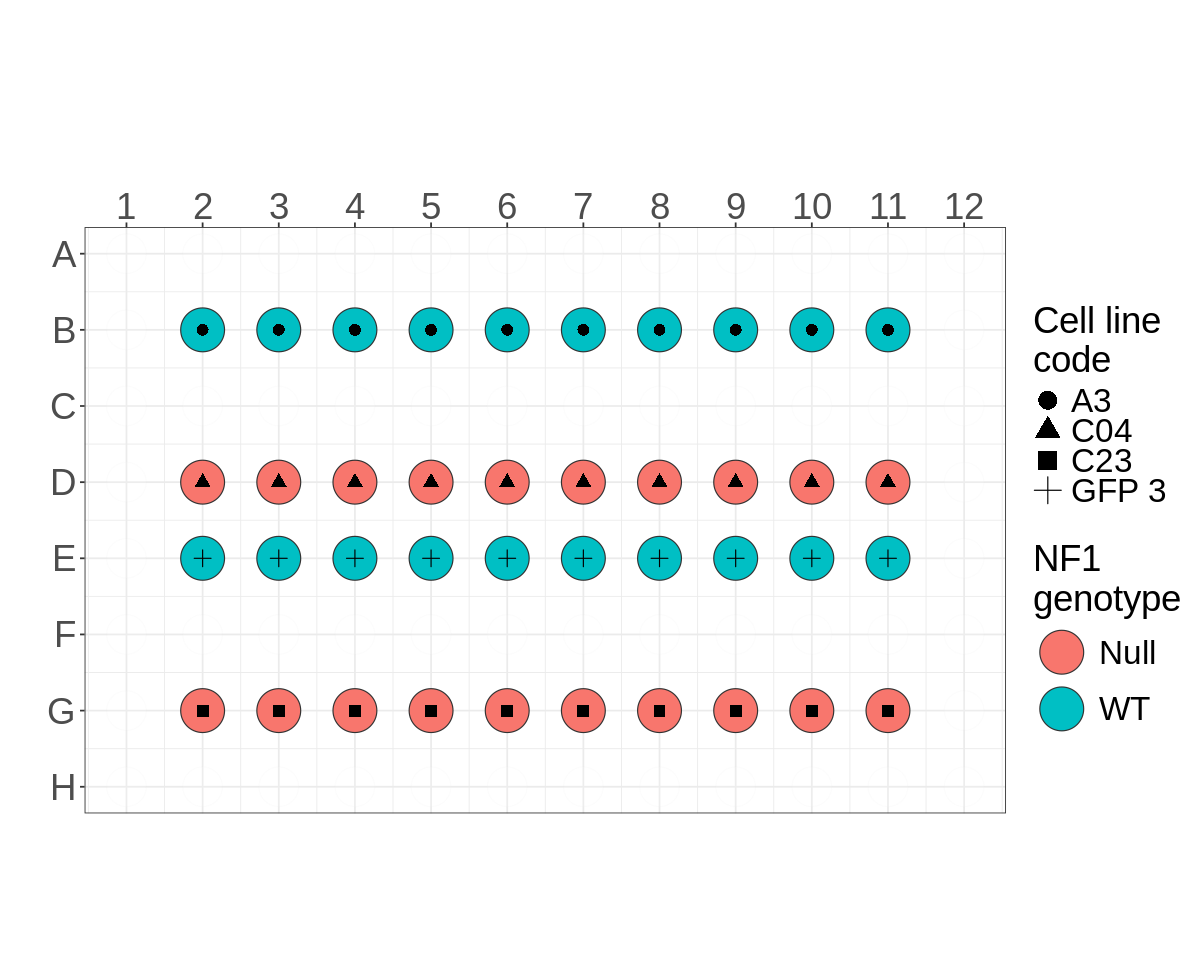

In [12]:
width <- 10
height <- 8
options(repr.plot.width = width, repr.plot.height = height)

# Generate platemap figure
platemap <-
    platetools::raw_map(
        data = platemap_df$genotype,
        well = platemap_df$well_position,
        plate = 96,
        size = 12
    ) +
    coord_fixed(ratio = 1.0) +
    ggplot2::scale_fill_discrete(name = "NF1\ngenotype") +
    ggplot2::geom_point(aes(shape = platemap_df$cell_line_code), size= 3) +
    ggplot2::scale_shape_discrete(name = "Cell line\ncode") +
    theme(
        legend.title = element_text(size = 22),  # Larger legend title
        legend.text = element_text(size = 20),  # Larger legend text
        axis.text = element_text(size = 22),  # Larger axis tick labels
        axis.title = element_text(size = 22)  # Larger axis titles
    ) +
    guides(
        shape = guide_legend(override.aes = list(size = 5)), 
    )

platemap

## Generate main figure 6

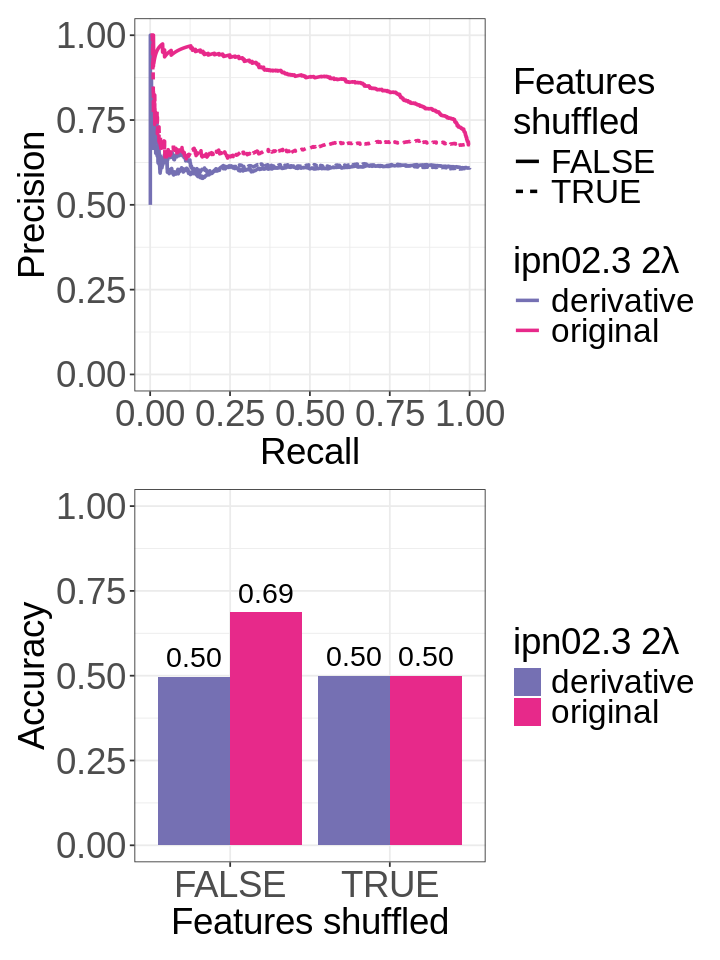

In [13]:
height <- 8
width <- 6
options(repr.plot.width = width, repr.plot.height = height)

right_plot <- (
    pr_curve_plot /
    accuracy_score_plot
) + plot_layout(heights = c(2,2))

right_plot

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


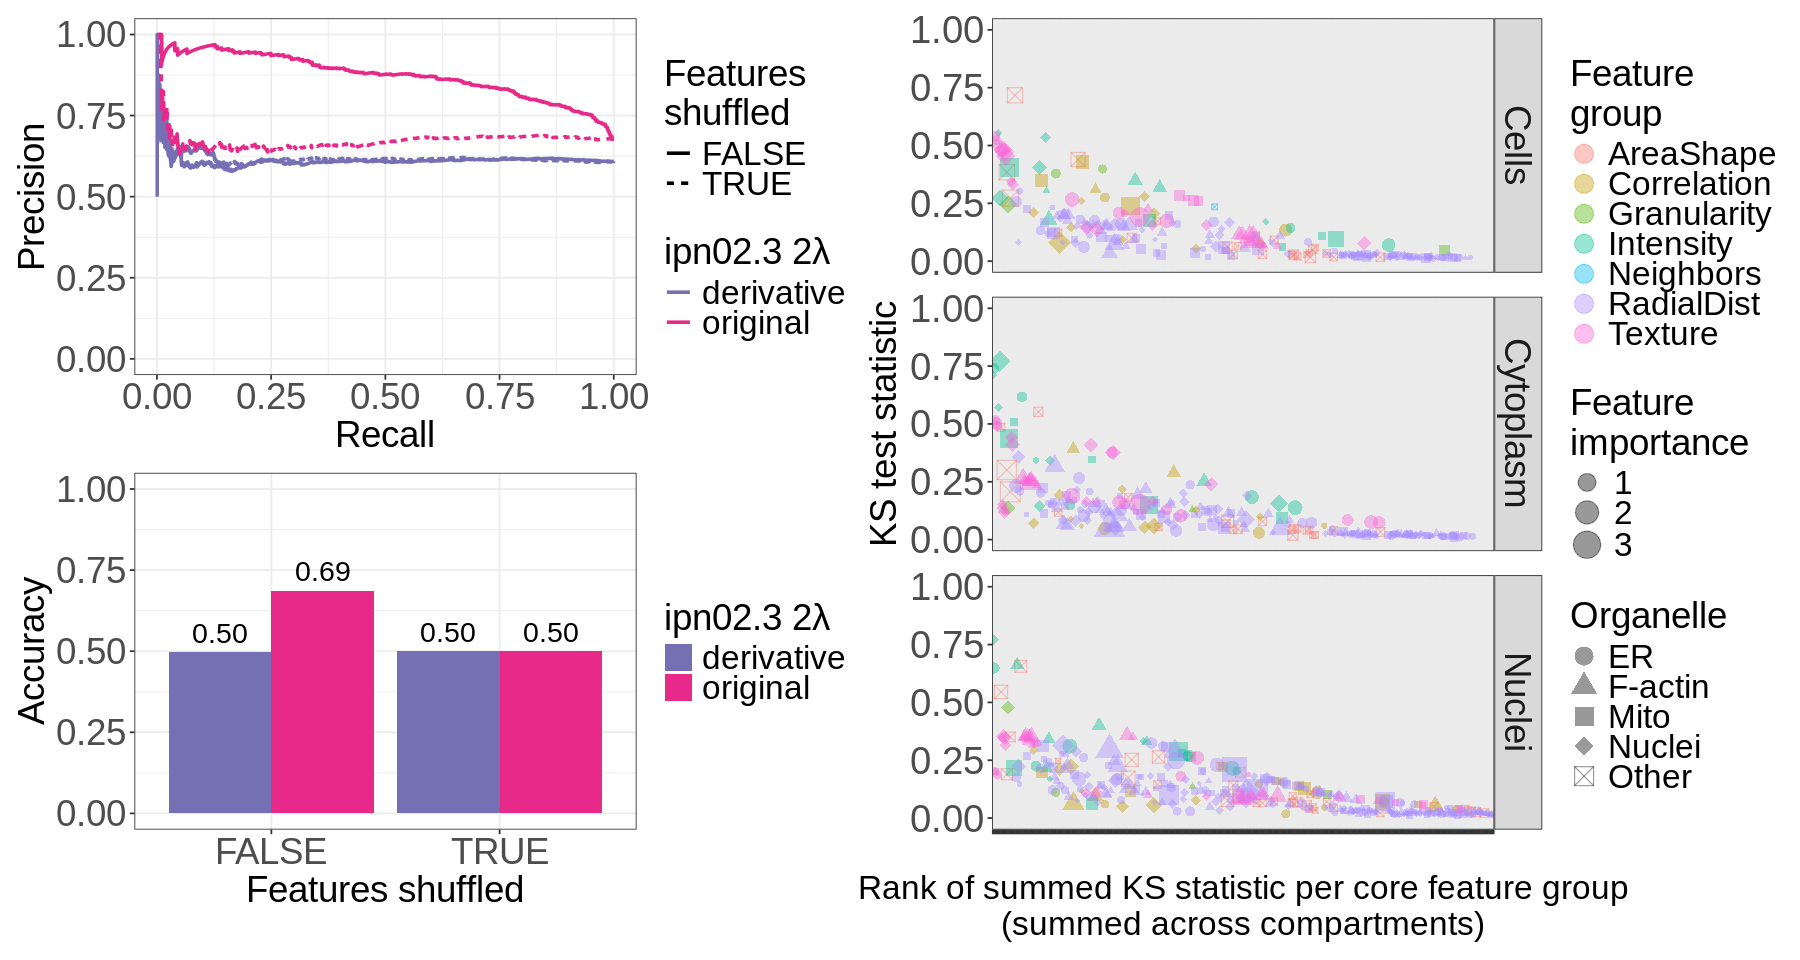

In [14]:
height <- 8
width <- 15
options(repr.plot.width = width, repr.plot.height = height)

align_bottom_plot <- (
    right_plot |
    ks_test_scatter
) + plot_layout(widths = c(1,1))

align_bottom_plot

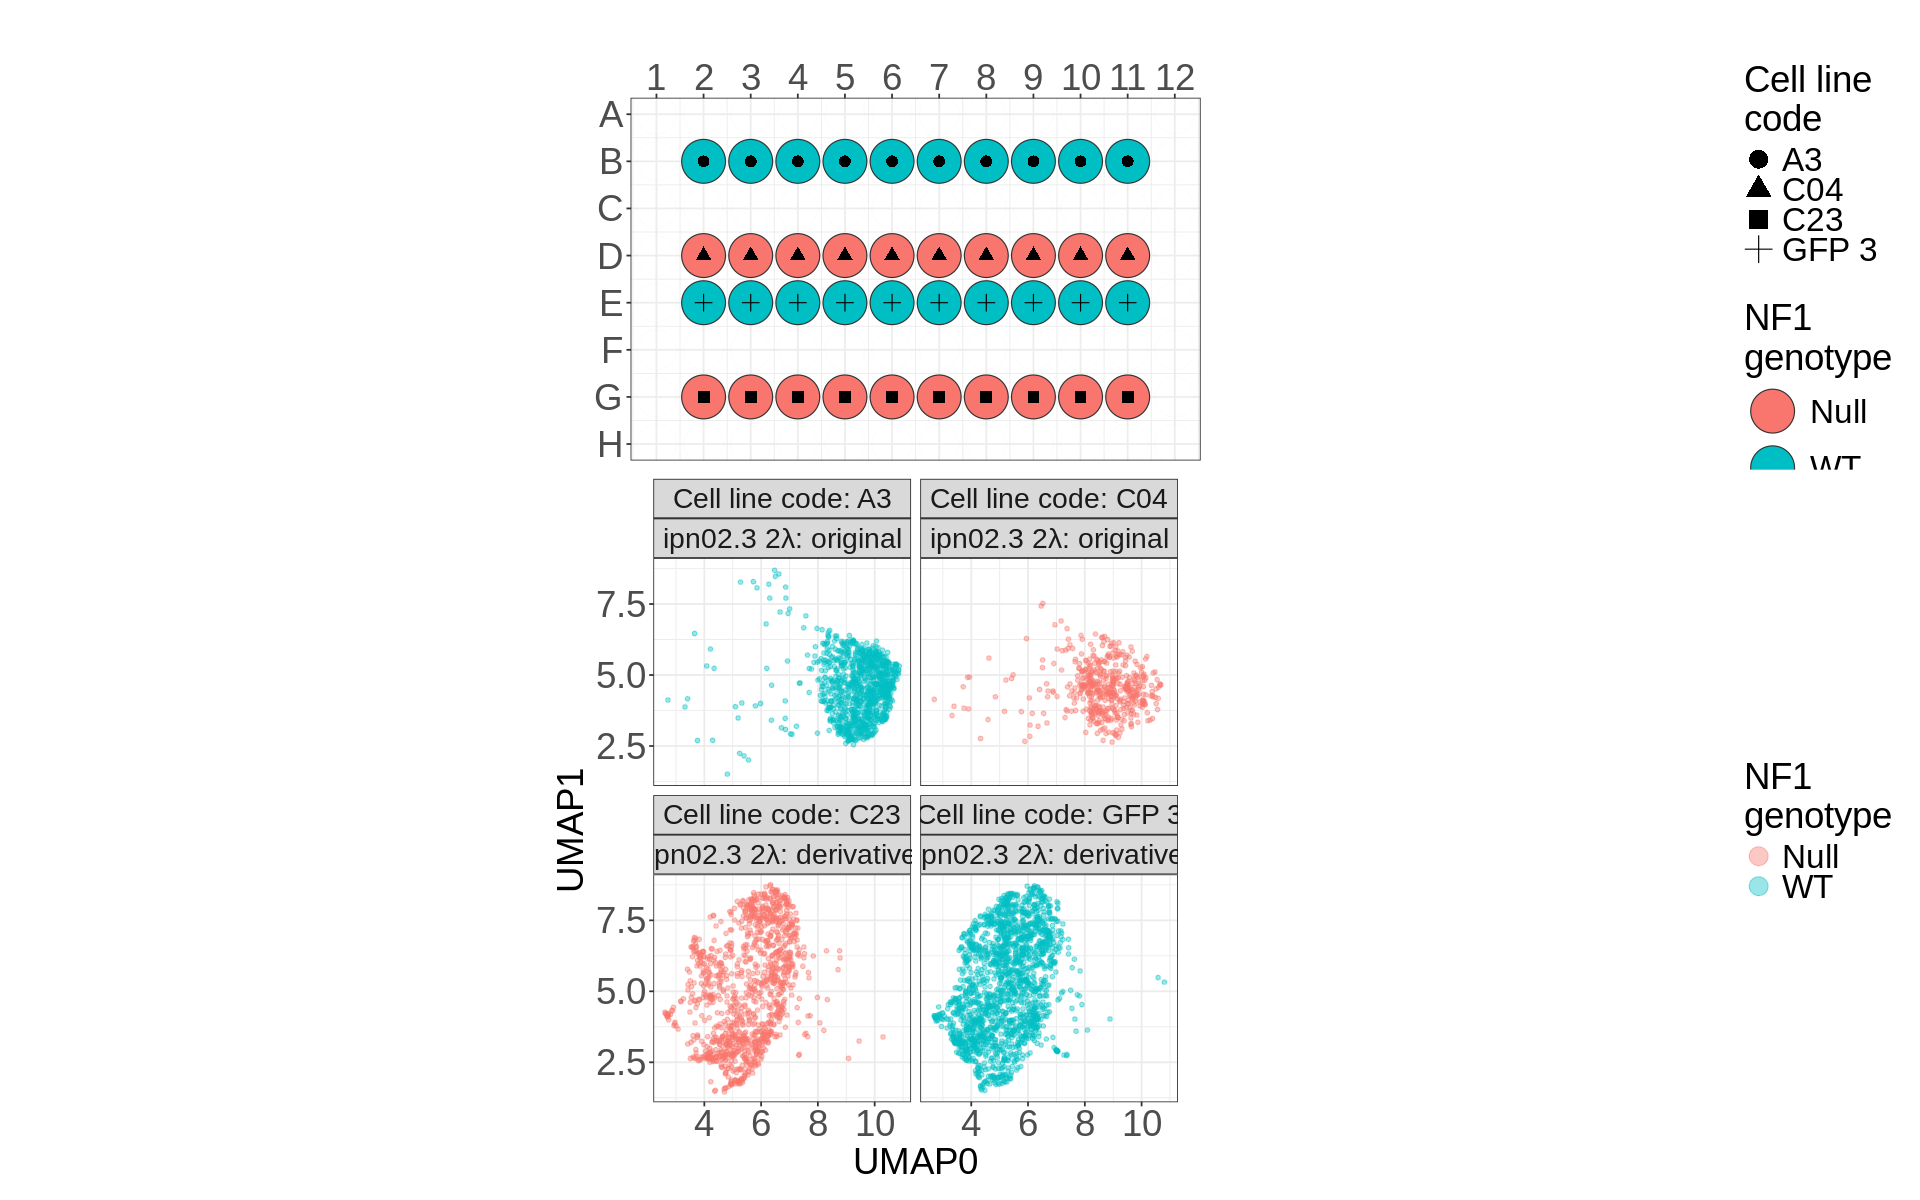

In [15]:
height <- 10
width <- 16
options(repr.plot.width = width, repr.plot.height = height)

platemap_umap <- (
    platemap /
    umap_fig_gg
) + plot_layout(heights = c(1,1.5))

platemap_umap

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


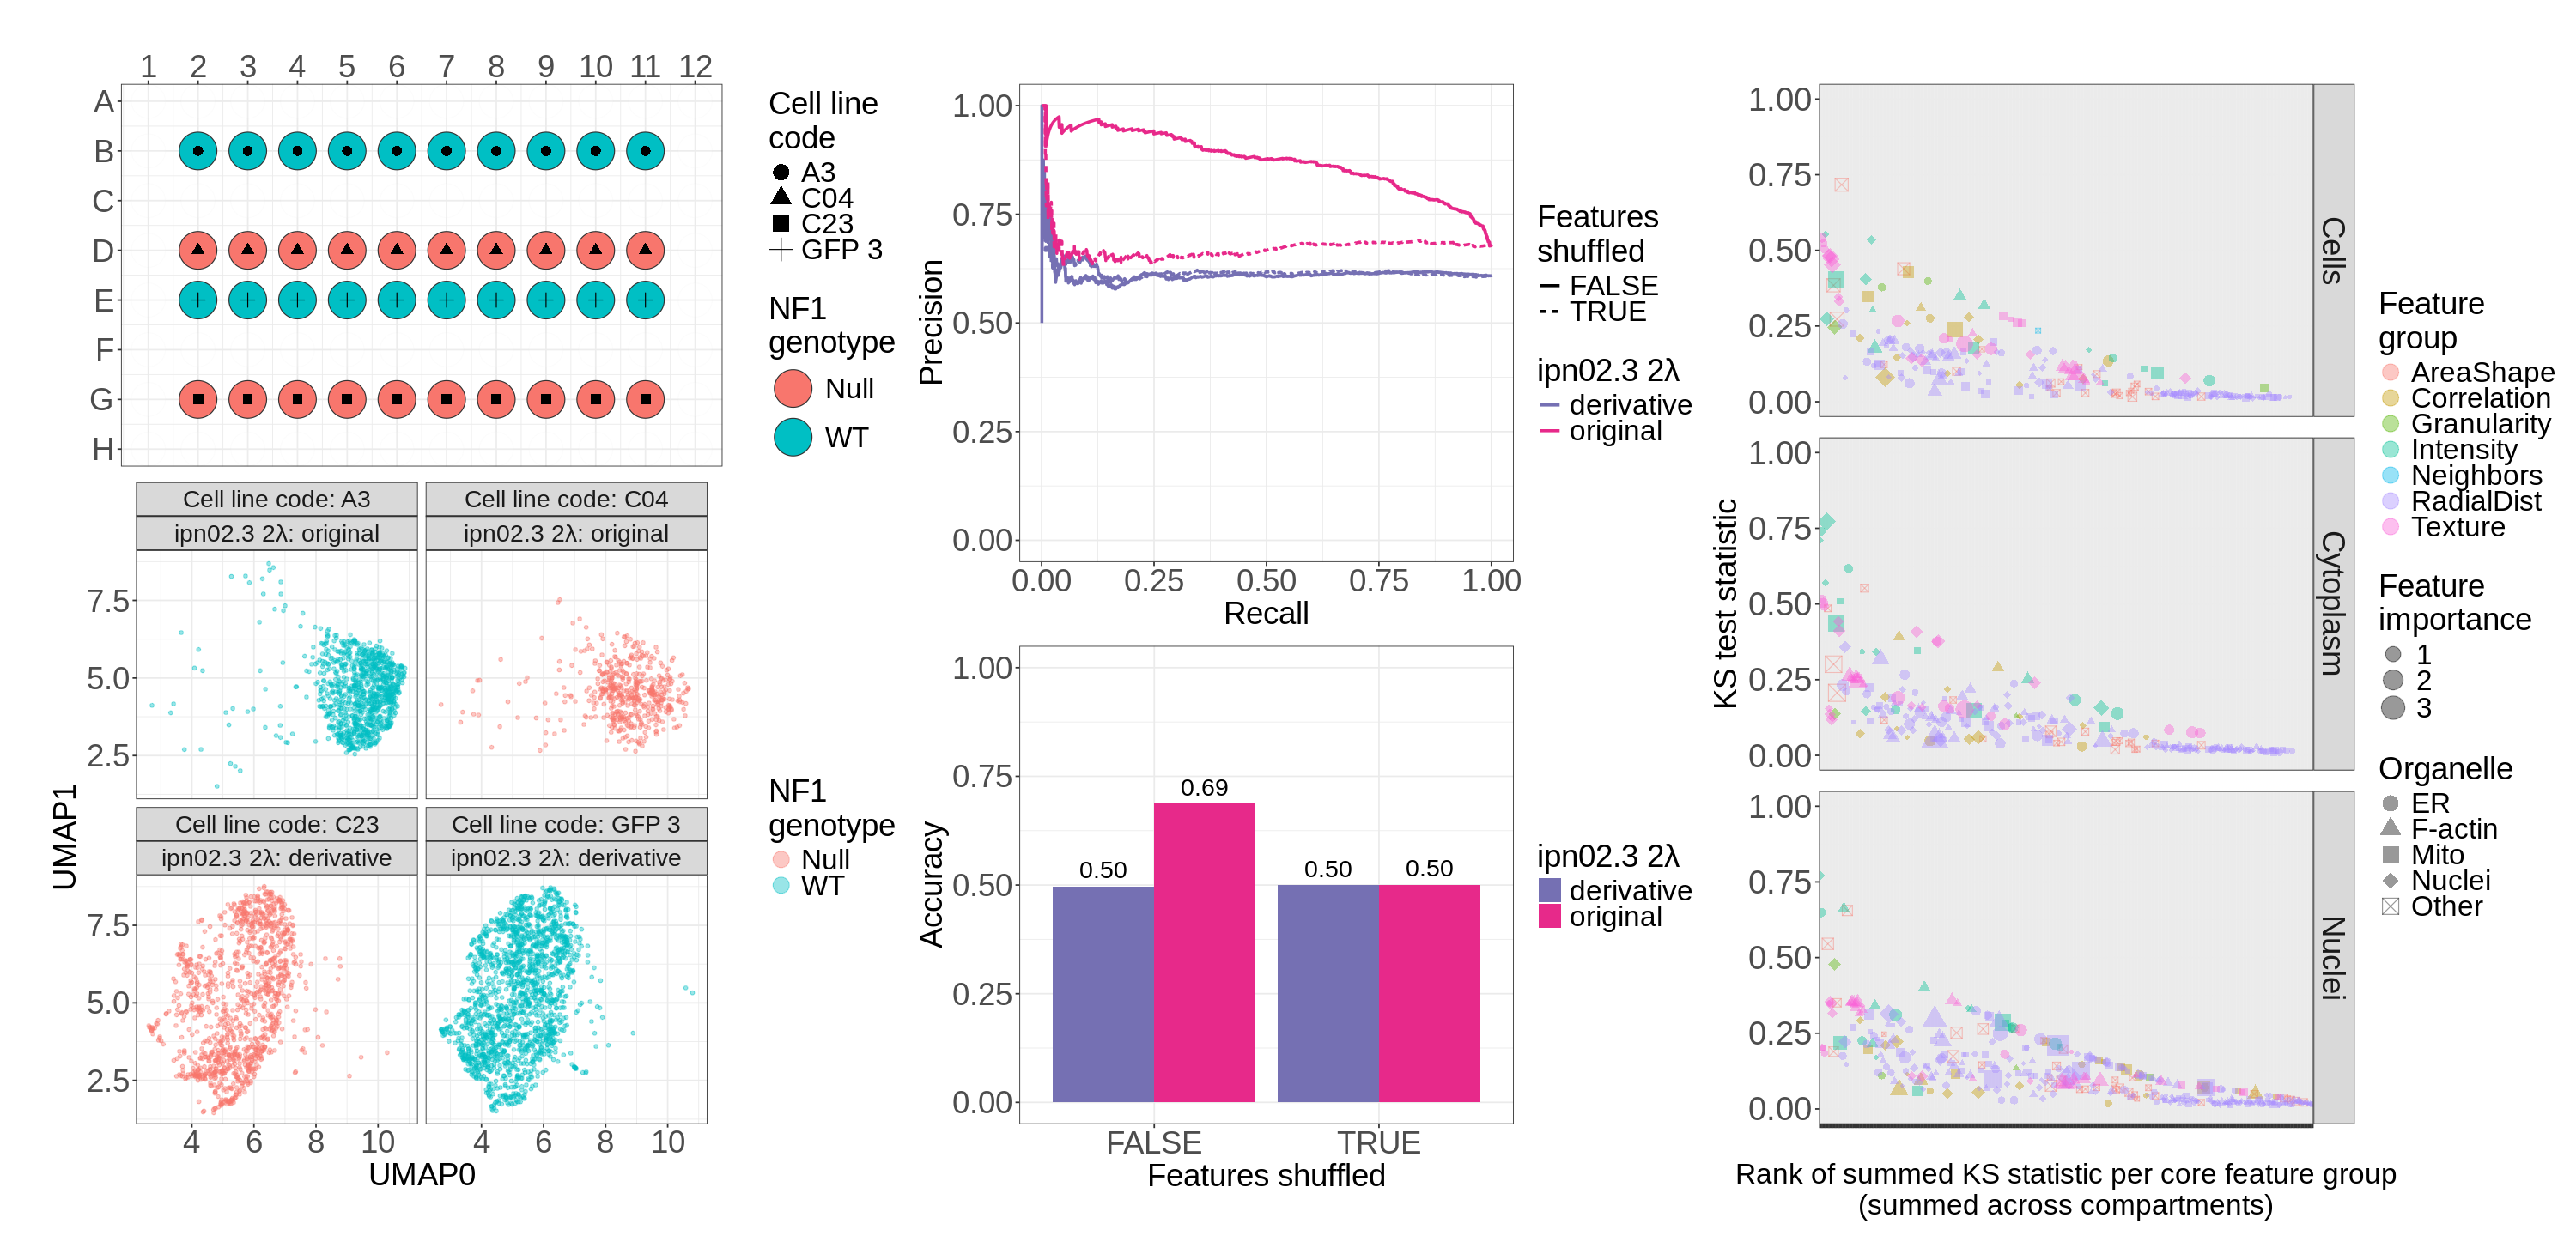

In [16]:
height <- 12
width <- 25
options(repr.plot.width = width, repr.plot.height = height)

align_plot <- (
    platemap_umap |
    align_bottom_plot
) + plot_layout(widths = c(0.5,1))

align_plot

In [17]:
fig_6_gg <- (
  align_plot
) + plot_annotation(tag_levels = "A") & theme(plot.tag = element_text(size = 25))

# Save the plot
ggsave(output_main_figure_6, plot = fig_6_gg, dpi = 500, height = height, width = width)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
